# Tutorial 04: Subsect Selection Methods

In [0]:
import itertools
import pandas as pd
import numpy as np
import copy

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Reset all styles to the default:
plt.rcParams.update(plt.rcParamsDefault)
# Then make graphs inline:
%matplotlib inline

In [0]:
# Set custom style settings:
# NB: We need to separate "matplotlib inline" call and these settings into different
# cells, otherwise the parameters are not set. This is a bug somewhere in Jupyter
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['lines.markersize'] = 10

In [0]:
#-- LOAD DATA:

hittersDF = pd.read_csv('Hitters.csv', na_values=[""])
# The first column has no name in the csv file:
hittersDF.rename(columns={hittersDF.columns[0] : "Name"}, inplace=True, copy=False)
hittersDF.set_index('Name', inplace=True)
hittersDF.dropna(inplace=True)

#-- CREATE X and y:

# Convert categorical variables into dummies:
dummies = pd.get_dummies(hittersDF[['League', 'Division', 'NewLeague']])
X = hittersDF.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1)
cat_features = ['League_N', 'Division_W', 'NewLeague_N']
num_features = list(X.columns)

X = pd.concat([X, dummies[cat_features]], axis=1).astype('float64')
y = hittersDF.Salary

display(X[0:10])

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Name,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1.0,1.0,1.0
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0.0,1.0,0.0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1.0,0.0,1.0
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1.0,0.0,1.0
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0.0,1.0,0.0
-Al Newman,185.0,37.0,1.0,23.0,8.0,21.0,2.0,214.0,42.0,1.0,30.0,9.0,24.0,76.0,127.0,7.0,1.0,0.0,0.0
-Argenis Salazar,298.0,73.0,0.0,24.0,24.0,7.0,3.0,509.0,108.0,0.0,41.0,37.0,12.0,121.0,283.0,9.0,0.0,1.0,0.0
-Andres Thomas,323.0,81.0,6.0,26.0,32.0,8.0,2.0,341.0,86.0,6.0,32.0,34.0,8.0,143.0,290.0,19.0,1.0,1.0,1.0
-Andre Thornton,401.0,92.0,17.0,49.0,66.0,65.0,13.0,5206.0,1332.0,253.0,784.0,890.0,866.0,0.0,0.0,0.0,0.0,0.0,0.0


## Best Subset Selection

In [0]:
#---- FUNCTIONS:

#---- Go through all combinations of features:
def findBestSubsetFixedSize(X, y, subset_size):
    features_nmb = X.shape[1]
    best_subset = []
    best_mse = -1
    for idx_set in itertools.combinations(range(features_nmb), subset_size):
        X_subset = X.iloc[:, list(idx_set)]
        lin_reg = LinearRegression(fit_intercept=True, normalize=False)
        lin_reg.fit(X_subset, y)
        yhat = lin_reg.predict(X_subset)
        mse_resid = mean_squared_error(y, yhat)
        if best_mse < 0 or mse_resid < best_mse:
            best_subset = list(idx_set)
            best_mse = mse_resid
    return([best_subset, best_mse])

def findBestSubset(X, y, max_subset_size):
    best_subsets = [None] * max_subset_size
    best_mses = [None] * max_subset_size
    for subset_size in range(1, max_subset_size + 1):
        best_subsets[subset_size-1], best_mses[subset_size-1] =\
            findBestSubsetFixedSize(X, y, subset_size)

    return([best_subsets, best_mses])

#---- EXECUTABLE CODE:

# Since the exhaustive search takes a really long time to complete,
# I recorded the result of this procedure
run_exhaustive_search = False
if run_exhaustive_search:
    # This procedure takes really long time to complete!
    best_subsets, best_mses = findBestSubset(X, y, 3)
else:
    best_subsets = [[11],
                    [1, 11],
                    [1, 11, 13],
                    [1, 11, 13, 17],
                    [0, 1, 11, 13, 17],
                    [0, 1, 5, 11, 13, 17],
                    [1, 5, 7, 8, 9, 13, 17],
                    [0, 1, 5, 9, 10, 12, 13, 17],
                    [0, 1, 5, 7, 10, 11, 12, 13, 17],
                    [0, 1, 5, 7, 10, 11, 12, 13, 14, 17],
                    [0, 1, 5, 7, 10, 11, 12, 13, 14, 16, 17],
                    [0, 1, 3, 5, 7, 10, 11, 12, 13, 14, 16, 17],
                    [0, 1, 3, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17],
                    [0, 1, 2, 3, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17],
                    [0, 1, 2, 3, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17],
                    [0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17],
                    [0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18],
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18],
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]]
    best_mses = [138619.46074728668, 117871.38419374169, 112931.6480921518,
                 108414.15432486929, 105641.63203117333, 102323.84346716877,
                 101594.30392401466, 98964.2910982682, 98079.25449243843,
                 97223.81562595078, 97160.73725673252, 97332.92951708901,
                 97546.77846683317, 97776.85642254839, 98118.12694421364,
                 98452.75395499919, 98814.06839444482, 99187.85802719608,
                 99591.35617968217]
    
adjr2s = [None] * len(best_subsets)
bics = [None] * len(best_subsets)
aics = [None] * len(best_subsets)
for idx_set in range(len(best_subsets)):
    X_subset = X.iloc[:, best_subsets[idx_set]].values
    X_subset = sm.tools.tools.add_constant(X_subset)
    result = sm.OLS(y, X_subset).fit()
    adjr2s[idx_set] = result.rsquared_adj
    bics[idx_set] = result.bic
    aics[idx_set] = result.aic

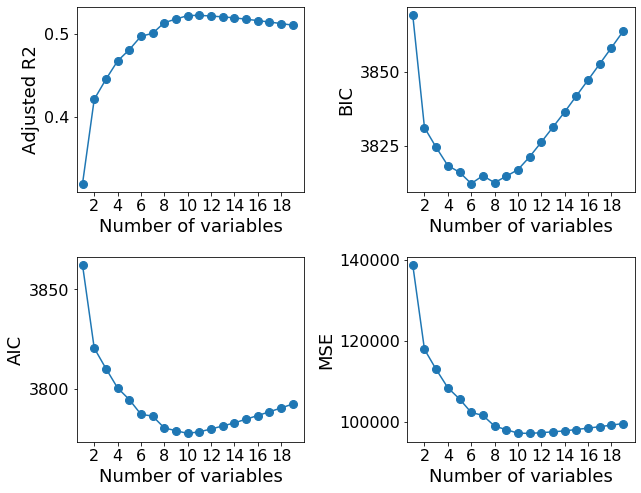

In [0]:
# Make plots of the best subset:

def makePlotsForBestSubsets(adjr2s, bics, aics, mses):
    markerSize = 8
    titlesFontSize = 18
    axisLabelFontSize = 16
    
    subsetsNmb = len(adjr2s)
    xvals = range(1, subsetsNmb + 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
    plt.subplots_adjust(wspace=0.45, hspace=0.35) 

    ax1.plot(xvals, adjr2s, '-o', markersize=markerSize)
    ax1.set_ylabel('Adjusted R2', fontsize=titlesFontSize)

    ax2.plot(xvals, bics, '-o', markersize=markerSize)
    ax2.set_ylabel('BIC', fontsize=titlesFontSize)

    ax3.plot(xvals, aics, '-o', markersize=markerSize)
    ax3.set_ylabel('AIC', fontsize=titlesFontSize)

    ax4.plot(xvals, mses, '-o', markersize=markerSize)
    ax4.set_ylabel('MSE', fontsize=titlesFontSize)

    for ax in fig.axes:
        ax.set_xlabel('Number of variables', fontsize=titlesFontSize)
        ax.set_xlim(0.5, subsetsNmb + 1)
        ax.set_xticks(range(2, subsetsNmb + 1, 2));
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(axisLabelFontSize) 
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(axisLabelFontSize)
            
makePlotsForBestSubsets(adjr2s, bics, aics, best_mses)

## Forward and Backward Stepwise Selection

In [0]:
#-- BACKWARD SELECTION:

def doBwdSelectStep(X, y, cur_subset):
    best_subset = []
    best_mse = -1
    for feature_idx in cur_subset:
        reduced_subset = list(set(cur_subset) - {feature_idx})
        X_subset = X.iloc[:, reduced_subset]
        lin_reg = LinearRegression(fit_intercept=True, normalize=False)
        lin_reg.fit(X_subset, y)
        yhat = lin_reg.predict(X_subset)
        mse_resid = mean_squared_error(y, yhat)
        if best_mse < 0 or mse_resid < best_mse:
            best_subset = reduced_subset
            best_mse = mse_resid
    return([best_subset, best_mse])

def doBwdStepwiseSelect(X, y, starting_set):
    steps_nmb = len(starting_set)
    best_subsets = [None] * steps_nmb
    best_mses = [None] * steps_nmb

    X_subset = X.iloc[:, starting_set]
    lin_reg = LinearRegression(fit_intercept=True, normalize=False)
    lin_reg.fit(X_subset, y)
    yhat = lin_reg.predict(X_subset)
    mse_resid = mean_squared_error(y, yhat)

    best_subsets[0] = starting_set
    best_mses[0] = mse_resid

    for step in range(steps_nmb - 1):
        best_subsets[step+1], best_mses[step+1] = doBwdSelectStep(X, y, best_subsets[step])
    return([best_subsets, best_mses])

#-- FORWARD SELECTION:

def doFwdSelectStep(X, y, cur_subset):
    features_nmb = X.shape[1]
    new_features = set(range(features_nmb)) - set(cur_subset)

    best_subset = []
    best_mse = -1
    for feature_idx in new_features:
        increased_subset = cur_subset + [feature_idx]
        X_subset = X.iloc[:, increased_subset]
        lin_reg = LinearRegression(fit_intercept=True, normalize=False)
        lin_reg.fit(X_subset, y)
        yhat = lin_reg.predict(X_subset)
        mse_resid = mean_squared_error(y, yhat)
        if best_mse < 0 or mse_resid < best_mse:
            best_subset = increased_subset
            best_mse = mse_resid
    return([best_subset, best_mse])

def doFwdStepwiseSelect(X, y, starting_set):
    features_nmb = X.shape[1]
    steps_nmb = features_nmb - len(starting_set)
    best_subsets = [None] * steps_nmb
    best_mses = [None] * steps_nmb
    prev_subset = starting_set
    for step in range(steps_nmb):
        best_subsets[step], best_mses[step] = doFwdSelectStep(X, y, prev_subset)
        prev_subset = best_subsets[step]
    return([best_subsets, best_mses])

#-- RUN BACKWARD AND FORWARD STEPWISE SELECTION:

best_bwd_subsets, best_bwd_mses = doBwdStepwiseSelect(X, y, list(range(19)))
# Reverse the lists:
best_bwd_subsets = best_bwd_subsets[::-1]
best_bwd_mses = best_bwd_mses[::-1]
bwd_sets_nmb = len(best_bwd_subsets)
bwd_adjr2s = [None] * bwd_sets_nmb
bwd_bics = [None] * bwd_sets_nmb
bwd_aics = [None] * bwd_sets_nmb
for idx_set in range(bwd_sets_nmb):
    X_subset = X.iloc[:, best_bwd_subsets[idx_set]].values
    X_subset = sm.tools.tools.add_constant(X_subset)
    result = sm.OLS(y, X_subset).fit()
    bwd_adjr2s[idx_set] = result.rsquared_adj
    bwd_bics[idx_set] = result.bic
    bwd_aics[idx_set] = result.aic

best_fwd_subsets, best_fwd_mses = doFwdStepwiseSelect(X, y, [])
fwd_sets_nmb = len(best_fwd_subsets)
fwd_adjr2s = [None] * fwd_sets_nmb
fwd_bics = [None] * fwd_sets_nmb
fwd_aics = [None] * fwd_sets_nmb
for idx_set in range(fwd_sets_nmb):
    X_subset = X.iloc[:, best_fwd_subsets[idx_set]].values
    X_subset = sm.tools.tools.add_constant(X_subset)
    result = sm.OLS(y, X_subset).fit()
    fwd_adjr2s[idx_set] = result.rsquared_adj
    fwd_bics[idx_set] = result.bic
    fwd_aics[idx_set] = result.aic


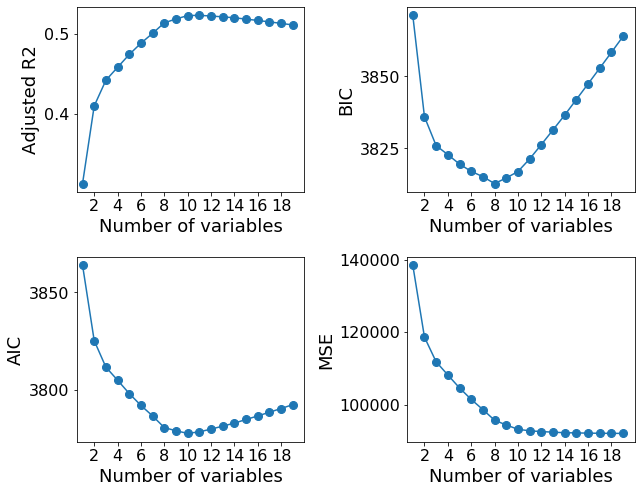

In [0]:
# Make plots for backward subsets:
makePlotsForBestSubsets(bwd_adjr2s, bwd_bics, bwd_aics, best_bwd_mses)

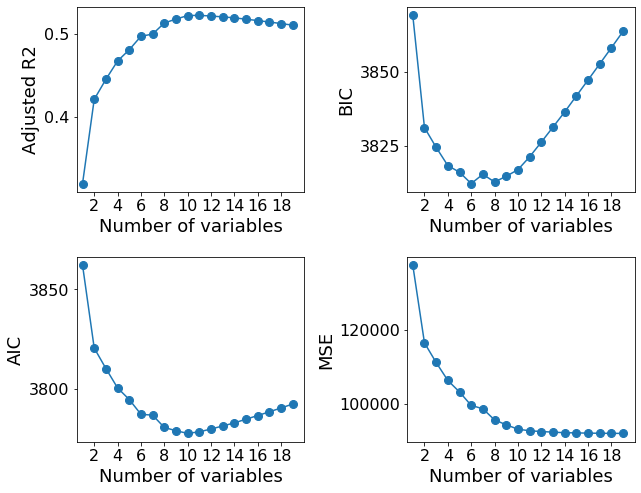

In [0]:
# Make plots for forward subsets:
makePlotsForBestSubsets(fwd_adjr2s, fwd_bics, fwd_aics, best_fwd_mses)